`SOW-BKI230A-2022-SEM2-V Deep Learning Assignment 5 Convolutional Neural Networks; Generative Adversarial Networks`

**Name**:

Replace this line with your name.

**S-number**:

Replace this line with your s-number.

### Generating gameboy characters with generative adversarial networks

In this assignment, you will study, complete and customise the accompanying partial implementation of a generative adversarial network by following the step-by-step instructions in the comments. Your goal is to train your generative adversarial network on the accompanying 0x72.itch.io-scraped dataset of 185472 16 × 16 pixel 2-bit gameboy-character-like images to generate the coolest characters that you can. Here is a sample of the dataset:

![](https://umuguc.github.io/file-sharing/gbc_dataset_5.gif)

You should document your experiments at the end of this notebook and submit it together with a sample of your characters.

NB: Once again, there will be a surprise prize for the student whose characters the class likes the most.

In [1]:
import random
import math
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
!wget -nc https://umuguc.github.io/file-sharing/gbc_dataset.npy.zip
!unzip -n gbc_dataset.npy.zip -d assignment_5

File ‘gbc_dataset.npy.zip’ already there; not retrieving.

Archive:  gbc_dataset.npy.zip


In [5]:
class GBCDataset(Dataset):
    """Implement gameboy character dataset (GBCDataset) class."""
    def __init__(self, data, device):
        self.dat = data
        self.dev = device

    def __len__(self):
        return self.dat.shape[0]

    def __getitem__(self, index):
        return torch.from_numpy(self.dat[index].astype(np.float32) / 127.5 - 1.0).to(self.dev)

In [6]:
data_list = np.load("assignment_5/gbc_dataset.npy")

# select how much data you want to use
data_percentage = 1.0
desired_size = int(len(data_list) * data_percentage)

# throw away half of every image, since they are symmetrical
data_list = data_list[:desired_size]
data_list = np.array([[img[0][:, :img.shape[1] // 2]] for img in data_list])

# put the data into a data loader
data_set = GBCDataset(data_list, device)
data_loader = DataLoader(data_set, batch_size=32, shuffle=True)

# save the (four) different color pigments
colors = np.unique(data_list[0][0])
colors

array([  0, 120, 232, 255], dtype=uint8)

In [7]:
class GBCGAN:
    """
    Implement gameboy character generative adversarial network (GBCGAN) class.

    Attributes:
        _dis_net (nn.Sequential): Discriminator network.
        _dis_opt (optim.Optimizer): Discriminator optimiser.
        _gen_net (nn.Sequential): Generator network.
        _gen_opt (optim.Optimizer): Generator optimiser.
        _lat_dim (int): Latent dimensionality.
    """

    def __init__(self, device: str = "cuda") -> None:
        self.dev = device
        self._dis_net, self._dis_opt = self._get_discriminator()
        self._gen_net, self._gen_opt = self._get_generator()
        self._lat_dim = self._gen_net[0].in_channels

    def _get_discriminator(self) -> Tuple[nn.Sequential, optim.Optimizer]:
        """Get discriminator network and discriminator optimiser."""

        # inputs  are [batch size] × 1 × 16 × 8 fake or real images and
        # outputs are [batch size] × 1 ×  1 × 1 fake or real probabilities.

        network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(4, 2), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        ).to(self.dev)

        optimiser = optim.Adam(network.parameters(), lr=0.0002, betas=(0.5, 0.999))
        return network, optimiser

    def _get_generator(self) -> Tuple[nn.Sequential, optim.Optimizer]:
        """Get generator network and generator optimiser."""
        
        # inputs  are [batch size] × [latent dimensionality] ×  1 × 1 random latents and
        # outputs are [batch size] ×                       1 × 16 × 8 fake images.

        network = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(4, 2), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        ).to(self.dev)

        optimiser = optim.Adam(network.parameters(), lr=0.0002, betas=(0.5, 0.999))
        return network, optimiser

    def generate_images(self, batch_size):
        """Create a canvas with batch_size * batch_size generated images."""
        
        # generate fake images
        random_latents = torch.randn(batch_size * batch_size, self._lat_dim, 1, 1, device=self.dev)
        temp_images = self._gen_net(random_latents)
        
        # create a canvas for the fake images
        padding = 2
        canvas_size = 16 * batch_size + padding * (batch_size + 1)
        canvas = Image.new("L", (canvas_size, canvas_size), color='white')

        for y in range(batch_size):
            for x in range(batch_size):
                # create the full image by mirroring
                image = 127.5 * (temp_images[y * batch_size + x][0].cpu().detach().numpy() + 1.0)  # left half
                image = np.concatenate((image, np.flip(image, axis=1)), axis=1)   # left half plus mirrored

                # convert all the colors to one of the original colors
                image = np.vectorize(lambda value: min(colors, key=lambda x: abs(x - value)))(image)
                image = image.astype(np.uint8)

                # put all the image on the canvas
                position = ((16 + padding) * y + padding, (16 + padding) * x + padding)
                canvas.paste(Image.fromarray(image), position)

        # upscale the image
        scale = 6
        newsize = (canvas.size[0] * scale, canvas.size[1] * scale)
        return canvas.resize(newsize, resample=Image.Resampling.BOX)

    def train_networks(self, data_loader: DataLoader, epoch_number: int=1) -> None:
        """
        Train discriminator network and generator network.

        Args:
            data_loader (DataLoader): GBC data loader.
            epoch_number (int): Epochs number.
        """
        self._dis_net.train()
        self._gen_net.train()

        for epoch in range(epoch_number):
            discriminator_losses = []
            generator_losses = []

            for real_images in data_loader:
                
                # DISCRIMINATOR TRAINING
                
                # generate fake images
                random_latents = torch.randn(data_loader.batch_size, self._lat_dim, 1, 1, device=self.dev)
                fake_images = self._gen_net(random_latents)
                
                # discriminate the real and fake images
                fake_probs = self._dis_net(fake_images).flatten()
                real_probs = self._dis_net(real_images).flatten()
                    
                # compute the loss
                predictions = torch.cat((fake_probs, real_probs))
                labels = torch.cat((torch.zeros_like(fake_probs), torch.ones_like(real_probs)))

                # compute the loss
                criterion = nn.MSELoss()
                discriminator_loss = criterion(predictions, labels)
                
                # backpropagate
                self._dis_opt.zero_grad()
                discriminator_loss.backward()
                self._dis_opt.step()

                discriminator_losses.append(discriminator_loss.item())

                # GENERATOR TRAINING

                # generate fake images
                random_latents = torch.randn(data_loader.batch_size, self._lat_dim, 1, 1, device=self.dev)
                fake_images = self._gen_net(random_latents)
                
                # discriminate the fake images
                fake_probs = self._dis_net(fake_images).flatten()
                
                # compute the loss
                criterion = nn.MSELoss()
                generator_loss = criterion(fake_probs, torch.ones_like(fake_probs))
                
                # backpropagate
                self._gen_opt.zero_grad()
                generator_loss.backward()
                self._gen_opt.step()

                generator_losses.append(generator_loss.item())

            print(f"Epoch: [{epoch + 1}/{epoch_number}]")
            print(f"Discriminator loss: {np.mean(discriminator_losses):.9f}")
            print(f"Generator loss: {np.mean(generator_losses):.9f}")

        self._dis_net.eval()
        self._gen_net.eval()

You can use the following code cells to train your networks and generate your images:

In [17]:
%%time

gbcgan = GBCGAN(device)
gbcgan.train_networks(data_loader, epoch_number=10)

Epoch: [1/10]
Discriminator loss: 0.043091108
Generator loss: 0.737351374
Epoch: [2/10]
Discriminator loss: 0.011961871
Generator loss: 0.891574914
Epoch: [3/10]
Discriminator loss: 0.007460666
Generator loss: 0.928229370
Epoch: [4/10]
Discriminator loss: 0.005815849
Generator loss: 0.945013217
Epoch: [5/10]
Discriminator loss: 0.004565849
Generator loss: 0.956455509
Epoch: [6/10]
Discriminator loss: 0.004258073
Generator loss: 0.960626093
Epoch: [7/10]
Discriminator loss: 0.004078145
Generator loss: 0.962733649
Epoch: [8/10]
Discriminator loss: 0.004344593
Generator loss: 0.962118753
Epoch: [9/10]
Discriminator loss: 0.004022767
Generator loss: 0.965779887
Epoch: [10/10]
Discriminator loss: 0.004751192
Generator loss: 0.961152068
CPU times: user 4min 11s, sys: 2 s, total: 4min 13s
Wall time: 4min 19s


In [19]:
fake_images = gbcgan.generate_images(20)

fake_images.show()
fake_images.save("fake_images.png")

Bonus question:

Considering the characteristics of the dataset, can you think of a way to make the generative adversarial network approximately twice as fast?

WRITE YOUR ANSWER BELOW:

All of the images are symmetrical of the y-axis, so instead of learning the whole image, we can just learn half of it and then mirror to get a full image. This way we only need to train on half of the original data!

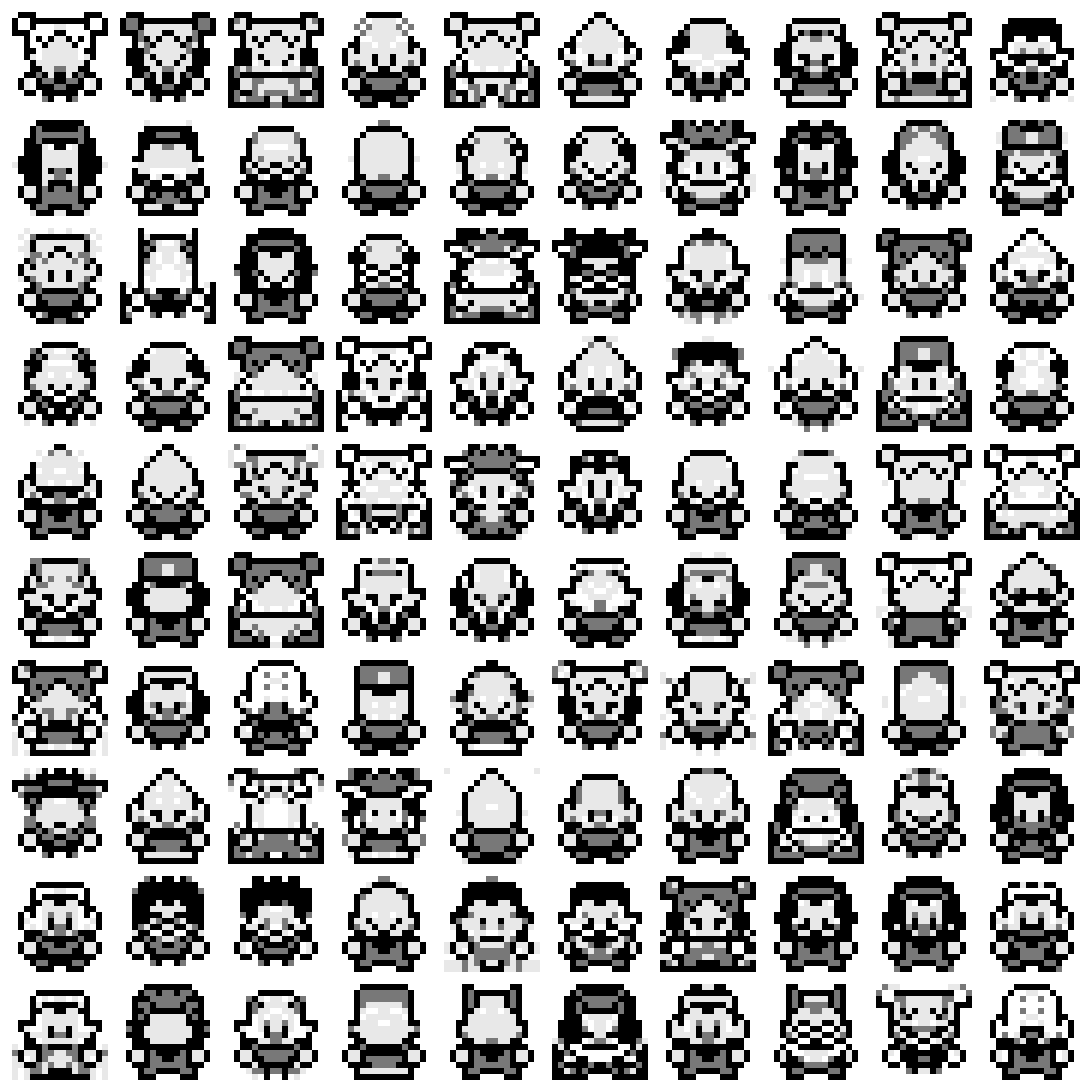